# Blocky
A blocksim simulation of NaviSim blocks

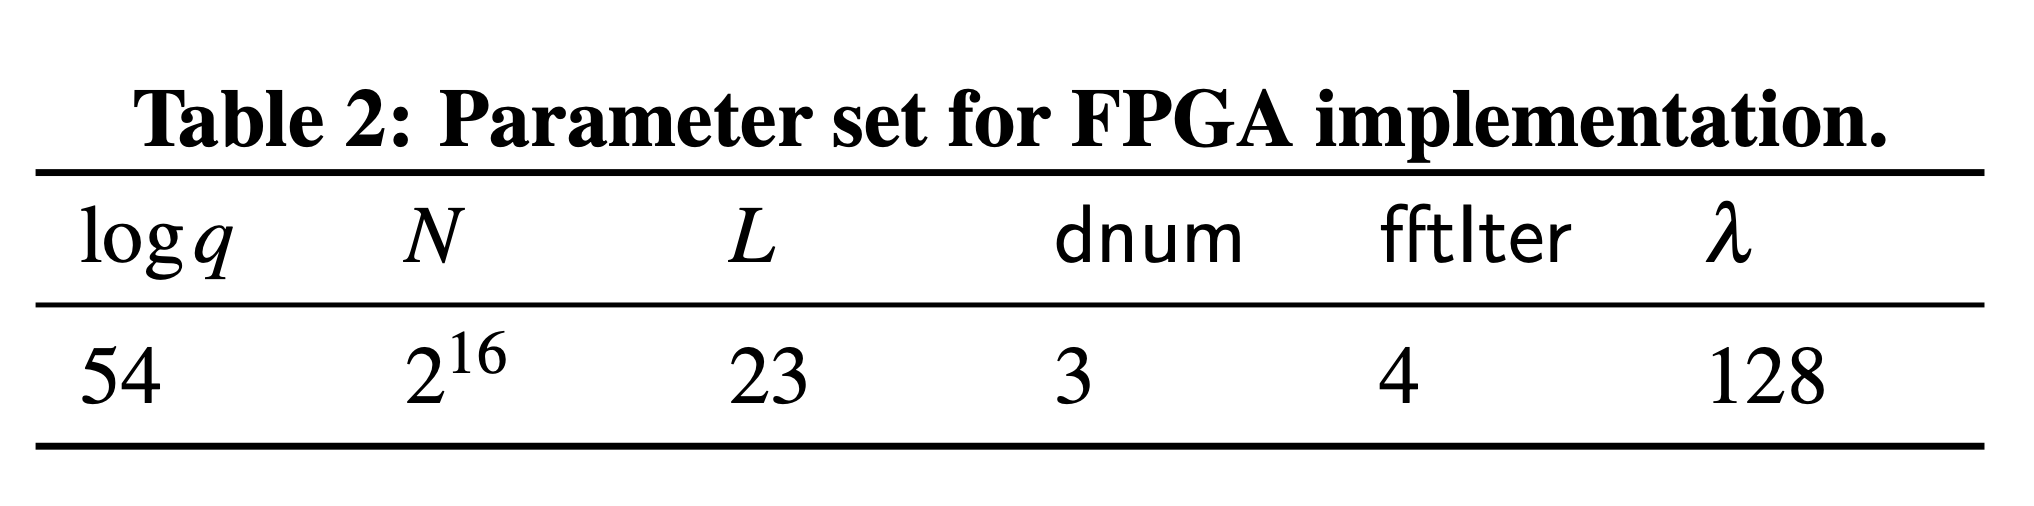

- Original Limbs (L): 23
- dnum: 3
- Extension Limbs = ceil((L + 1)/dnum) = 8


## Mod Raise

(original limbs * mult_latency) + ( dnum * ( original limbs * extension limbs * mult_add_latency))

(23 * MULT) + (3 * (23 * 9 * ADD)) = 23 * MULT + 3 * 23 * 9 * ADD

23 Scalar Mult

621 PolyADD

## Mod Down

(2* extension limbs * intt_cycles) + 2*((extension limbs*mult_cycles)+ (original limbs * extension limbs * mult_add_latency)) + (2 * original limbs*ntt_cycles) + (2 * sub_latency)+(2*mult_latency)

- INTT = 2 * 9 = 18
- Scalar Mult = 2 * 9 = 18
- Add = 2 * 23 * 9 = 414
- NTT = 2 * 23 = 46
- Sub = 2
- Scalar Mult = 2


In [1]:
# Imports
import numpy as np
import pandas as pd
# Import NetworkX
import networkx as nx
# Import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [2]:
# Config
tick_res = 10.0 # 1000 ticks per microsecond

list_of_kernels = ['ntt_32', 'intt_32', 'point_mult_32', 'scalar_mult_32', 'point_add_32',
                   'point_sub_32', 'rotate_32', 'ntt_64', 'intt_64', 'point_mult_64',
                   'scalar_mult_64', 'point_add_64', 'point_sub_64', 'rotate_64']


# Create metrics DF
metrics = pd.DataFrame(columns=['CUs_busy', 'DRAM_BW', 'L1_BW', 'L2_BW', 'IPC', 'instx', 'DRAM_reads', 'DRAM_writes', 'dram_traffic', 'LDS'])
# Create a list of the metrics
CUs_busy = []
DRAM_BW = []
L1_BW = []
L2_BW = []
L1_HR = []
L2_HR = []
IPC = []
instx = []
DRAM_reads = []
DRAM_writes = []
dram_traffic = []
LDS_utilized = []


In [3]:
# Graph Tracing

def create_traces(G):
	node_trace = create_node_trace(G)
	edge_trace = create_edge_trace(G)
	return edge_trace, node_trace

def create_edge_trace(G):
	edge_x = []
	edge_y = []
	for edge in G.edges():
		x0, y0 = G.nodes[edge[0]]['pos']
		x1, y1 = G.nodes[edge[1]]['pos']
		edge_x.append(x0)
		edge_x.append(x1)
		edge_x.append(None)
		edge_y.append(y0)
		edge_y.append(y1)
		edge_y.append(None)

	edge_trace = go.Scatter(
		x=edge_x, y=edge_y,
		line=dict(width=0.5, color='#888'),
		hoverinfo='none',
		mode='lines')
	return edge_trace

def create_node_trace(G):
	node_x = []
	node_y = []
	for node in G.nodes():
		x, y = G.nodes[node]['pos']
		node_x.append(x)
		node_y.append(y)

	node_trace = go.Scatter(
		x=node_x, y=node_y,
		mode='markers',
		hoverinfo='text',
		marker=dict(
			showscale=True,
			# colorscale options
			#'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
			#'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
			#'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
			colorscale='YlGnBu',
			reversescale=True,
			color=[],
			size=10,
			colorbar=dict(
				thickness=15,
				title='Node Connections',
				xanchor='left',
				titleside='right'
			),
			line_width=2))
	node_types = []
	node_text = []
	# Iterate through nodes
	for node in G.nodes():
		node_types.append(type_chart(G.nodes[node]['type']))
		single_node_text = 	'Name: ' +  G.nodes[node]['kernel_name'] + '<br>' + \
							'Node: ' + str(node) + '<br>' + \
							'Type: ' + G.nodes[node]['type'] + '<br>' + \
							'Computed: ' + str(G.nodes[node]['computed']) + '<br>' + \
							'Tick Length: ' + str(G.nodes[node]['tick_length'])
		node_text.append(single_node_text)
	# for node, adjacencies in enumerate(G.adjacency()):
	# 	node_adjacencies.append(len(adjacencies[1]))
	# 	node_text.append('# of connections: '+str(len(adjacencies[1])))
	node_trace.marker.color = node_types
	node_trace.text = node_text
	return node_trace

def type_chart(type):
	if type == 'null':
		return len(list_of_kernels)
	# Find index in list_of_kernels
	index = list_of_kernels.index(type)
	# Return index
	return index

def plot_graph(G):
	pos = nx.spring_layout(G)
	# Assign positions to nodes
	for node in G.nodes():
		G.nodes[node]['pos'] = list(pos[node])
	edge_trace, node_trace = create_traces(G)
	fig = go.Figure(data=[edge_trace, node_trace],
		layout=go.Layout(
			title='<br>Compute Graph BlockSim',
			titlefont_size=16,
			showlegend=False,
			hovermode='closest',
			margin=dict(b=20,l=5,r=5,t=40),
			annotations=[ dict(
				text="Author: <a href='https://wiki.kaustubh.us'>\
					Kaustubh</a>",
				showarrow=False,
				xref="paper", yref="paper",
				x=0.005, y=-0.002 ) ],
			xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
			yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
		)
	fig.show()

In [4]:
# Read in the data
block_data = pd.read_csv('../data/AMD NTT Profiling - Block Sim.csv')
# Drop empty rows
# block_data = block_data.dropna()
# Transpose the data
block_data = block_data.T
# Rename the columns
block_data.columns = block_data.iloc[0]
# Drop the first row
block_data = block_data.drop(block_data.index[0])
# Convert the data to numeric
block_data = block_data.apply(pd.to_numeric)


In [5]:
# block_data


In [6]:
# GPU Metrics
max_CUs = 120
max_DRAM_BW = 0 #  1228.8 GB/s
max_L1_BW = 0
max_L2_BW = 0
max_IPC = 0
min_DRAM_latency = 0
DRAM_size = 0 # 32 GB
shared_memory_size = 0 # 64KB per CU
L1_size_per_cu = 0 # 16 KB
L2_size = 0 # 8MB
lds_capacity = 7.5 * 1024 # 7.5 MB (LDS capacity is in KB)

# Kernel Names
USE_32_BIT = False
USE_64_BIT = True
k_ntt = ''
k_intt = ''
k_point_mult = ''
k_scalar_mult = ''
k_point_add = ''
k_point_sub = ''
k_rotate = ''

if USE_32_BIT:
    k_ntt = 'ntt_32'
    k_intt = 'intt_32'
    k_point_mult = 'point_mult_32'
    k_scalar_mult = 'scalar_mult_32'
    k_point_add = 'point_add_32'
    k_point_sub = 'point_sub_32'
    k_rotate = 'rotate_32'
elif USE_64_BIT:
    k_ntt = 'ntt_64'
    k_intt = 'intt_64'
    k_point_mult = 'point_mult_64'
    k_scalar_mult = 'scalar_mult_64'
    k_point_add = 'point_add_64'
    k_point_sub = 'point_sub_64'
    k_rotate = 'rotate_64'

k_null = 'null'


## HE Blocks

In [7]:
# HE Block Functions

def get_tick_length(type, block_data):
	if type == 'null':
		return 0
	tick_length = float(block_data[type]['Exec Time us']) * tick_res # Resolution is 10 ticks per us
	return tick_length


def add_node_to_graph(compute_graph, node_type, uid, block_data, kernel_name):
	if node_type == '':
		print('Error: Node type is empty')
	current_tick_length = get_tick_length(node_type, block_data)
	compute_graph.add_node(uid, type=node_type, computed=False, tick_length=current_tick_length, remaining_ticks=current_tick_length, kernel_name=kernel_name)
	uid += 1
	return compute_graph, uid


def poly_mult(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'poly_mult')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'poly_mult')
	# Add point_mult
	point_mult1 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_point_mult, uid, block_data, 'poly_mult')
	# Add edges
	compute_graph.add_edge(start_node, point_mult1)
	compute_graph.add_edge(point_mult1, end_node)
	return uid, compute_graph, start_node, end_node


def he_add(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_add')
	end_node = uid

	add_count = 46 # 2 * 23
	for i in range(add_count):
		add_node = uid
		compute_graph, uid = add_node_to_graph(compute_graph, k_point_add, uid, block_data, 'he_add')
		compute_graph.add_edge(start_node, add_node)
		compute_graph.add_edge(add_node, end_node)

	return uid, compute_graph, start_node, end_node


def mod_raise(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'mod_raise')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'mod_raise')
	intermediate_mult_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'mod_raise')
	mult_count = 23
	add_count = 368
	for i in range(mult_count):
		mult_node = uid
		compute_graph, uid = add_node_to_graph(compute_graph, k_scalar_mult, uid, block_data, 'mod_raise')
		compute_graph.add_edge(start_node, mult_node)
		compute_graph.add_edge(mult_node, intermediate_mult_node)
	for i in range(add_count):
		add_node = uid
		compute_graph, uid = add_node_to_graph(compute_graph, k_point_add, uid, block_data, 'mod_raise')
		compute_graph.add_edge(intermediate_mult_node, add_node)
		compute_graph.add_edge(add_node, end_node)
	return uid, compute_graph, start_node, end_node


def mod_down(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'mod_down')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'mod_down')

	intt_count = 16
	scalar_mult_count_1 = 16
	add_count = 368
	ntt_count = 46
	sub_count = 2
	scalar_mult_count_2 = 2

	intermediate_node_0 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'mod_down')
	for i in range(intt_count):
		intt_node = uid
		compute_graph, uid = add_node_to_graph(compute_graph, k_intt, uid, block_data, 'mod_down')
		compute_graph.add_edge(start_node, intt_node)
		compute_graph.add_edge(intt_node, intermediate_node_0)
	
	intermediate_node_1 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'mod_down')
	for i in range(scalar_mult_count_1):
		scalar_mult_node_1 = uid
		compute_graph, uid = add_node_to_graph(compute_graph, k_scalar_mult, uid, block_data, 'mod_down')
		compute_graph.add_edge(intermediate_node_0, scalar_mult_node_1)
		compute_graph.add_edge(scalar_mult_node_1, intermediate_node_1)

	intermediate_node_2 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'mod_down')
	for i in range(add_count):
		add_node = uid
		compute_graph, uid = add_node_to_graph(compute_graph, k_point_add, uid, block_data, 'mod_down')
		compute_graph.add_edge(intermediate_node_1, add_node)
		compute_graph.add_edge(add_node, intermediate_node_2)

	intermediate_node_3 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'mod_down')
	for i in range(ntt_count):
		ntt_node = uid
		compute_graph, uid = add_node_to_graph(compute_graph, k_ntt, uid, block_data, 'mod_down')
		compute_graph.add_edge(intermediate_node_2, ntt_node)
		compute_graph.add_edge(ntt_node, intermediate_node_3)

	intermediate_node_4 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'mod_down')
	for i in range(sub_count):
		sub_node = uid
		compute_graph, uid = add_node_to_graph(compute_graph, k_point_sub, uid, block_data, 'mod_down')
		compute_graph.add_edge(intermediate_node_3, sub_node)
		compute_graph.add_edge(sub_node, intermediate_node_4)

	for i in range(scalar_mult_count_2):
		scalar_mult_node_2 = uid
		compute_graph, uid = add_node_to_graph(compute_graph, k_scalar_mult, uid, block_data, 'mod_down')
		compute_graph.add_edge(intermediate_node_4, scalar_mult_node_2)
		compute_graph.add_edge(scalar_mult_node_2, end_node)

	return uid, compute_graph, start_node, end_node


def he_rotate(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_rotate')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_rotate')
	
	intermediate_node_0 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_rotate')
	rotate_count = 46
	for i in range(rotate_count):
		rotate_node = uid
		compute_graph, uid = add_node_to_graph(compute_graph, k_rotate, uid, block_data, 'he_rotate')
		compute_graph.add_edge(start_node, rotate_node)
		compute_graph.add_edge(rotate_node, intermediate_node_0)
	# Add a key switch
	uid, compute_graph, start_node_ks, end_node_ks = key_switch(uid, compute_graph)
	compute_graph.add_edge(intermediate_node_0, start_node_ks)
	compute_graph.add_edge(end_node_ks, end_node)
	return uid, compute_graph, start_node, end_node

def key_switch(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'key_switch')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'key_switch')

	# Mod raise
	uid, compute_graph, start_node_1, end_node_1 = mod_raise(uid, compute_graph)
	compute_graph.add_edge(start_node, start_node_1)

	intermediate_node_0 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'key_switch')

	# Add 31 poly mults
	poly_mult_count = 31
	for i in range(poly_mult_count):
		uid, compute_graph, start_node_2, end_node_2 = poly_mult(uid, compute_graph)
		compute_graph.add_edge(end_node_1, start_node_2)
		compute_graph.add_edge(end_node_2, intermediate_node_0)

	# Mod Down
	uid, compute_graph, start_node_3, end_node_3 = mod_down(uid, compute_graph)
	compute_graph.add_edge(intermediate_node_0, start_node_3)

	compute_graph.add_edge(end_node_3, end_node)
	return uid, compute_graph, start_node, end_node

def poly_add(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'poly_add')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'poly_add')
	# Add
	add_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_point_add, uid, block_data, 'poly_add')
	compute_graph.add_edge(start_node, add_node)
	compute_graph.add_edge(add_node, end_node)
	return uid, compute_graph, start_node, end_node

def point_add(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'point_add')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'point_add')
	# Add
	add_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_point_add, uid, block_data, 'point_add')
	compute_graph.add_edge(start_node, add_node)
	compute_graph.add_edge(add_node, end_node)
	return uid, compute_graph, start_node, end_node

def he_mult(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_mult')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_mult')

	# Poly Mult
	intermediate_node_0 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_mult')
	poly_mult_count = 92 # 4*23
	for i in range(poly_mult_count):
		uid, compute_graph, start_node_1, end_node_1 = poly_mult(uid, compute_graph)
		compute_graph.add_edge(start_node, start_node_1)
		compute_graph.add_edge(end_node_1, intermediate_node_0)
	
	# Poly Add
	intermediate_node_1 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_mult')
	poly_add_count = 46 # 23*2
	for i in range(poly_add_count):
		uid, compute_graph, start_node_2, end_node_2 = poly_add(uid, compute_graph)
		compute_graph.add_edge(intermediate_node_0, start_node_2)
		compute_graph.add_edge(end_node_2, intermediate_node_1)
	
	# Key Switch
	uid, compute_graph, start_node_3, end_node_3 = key_switch(uid, compute_graph)
	compute_graph.add_edge(intermediate_node_1, start_node_3)

	# Rescale
	uid, compute_graph, start_node_4, end_node_4 = he_rescale(uid, compute_graph)
	compute_graph.add_edge(end_node_3, start_node_4)

	# End
	compute_graph.add_edge(end_node_4, end_node)

	return uid, compute_graph, start_node, end_node

def ntt(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'ntt')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'ntt')
	# NTT
	ntt_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_ntt, uid, block_data, 'ntt')
	compute_graph.add_edge(start_node, ntt_node)
	compute_graph.add_edge(ntt_node, end_node)
	return uid, compute_graph, start_node, end_node

def intt(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'intt')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'intt')
	# NTT
	intt_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_intt, uid, block_data, 'intt')
	compute_graph.add_edge(start_node, intt_node)
	compute_graph.add_edge(intt_node, end_node)
	return uid, compute_graph, start_node, end_node

def scalar_mult(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'scalar_mult')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'scalar_mult')
	# Scalar Mult
	scalar_mult_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_scalar_mult, uid, block_data, 'scalar_mult')
	compute_graph.add_edge(start_node, scalar_mult_node)
	compute_graph.add_edge(scalar_mult_node, end_node)
	return uid, compute_graph, start_node, end_node

def he_rescale(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_rescale')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_rescale')

	# intt
	intermediate_node_0 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_rescale')
	intt_count = 2
	for i in range(intt_count):
		uid, compute_graph, start_node_0, end_node_0 = intt(uid, compute_graph)
		compute_graph.add_edge(start_node, start_node_0)
		compute_graph.add_edge(end_node_0, intermediate_node_0)
	
	# scalar mult
	intermediate_node_1 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_rescale')
	scalar_mult_count = 44 # 2*(23-1)
	for i in range(scalar_mult_count):
		uid, compute_graph, start_node_1, end_node_1 = scalar_mult(uid, compute_graph)
		compute_graph.add_edge(intermediate_node_0, start_node_1)
		compute_graph.add_edge(end_node_1, intermediate_node_1)
	
	# Point add
	intermediate_node_2 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_rescale')
	poly_add_count = 44 # 2*(23-1)
	for i in range(poly_add_count):
		uid, compute_graph, start_node_2, end_node_2 = poly_add(uid, compute_graph)
		compute_graph.add_edge(intermediate_node_1, start_node_2)
		compute_graph.add_edge(end_node_2, intermediate_node_2)
	
	# ntt
	intermediate_node_3 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'he_rescale')
	ntt_count = 44 # 2*(23-1)
	for i in range(ntt_count):
		uid, compute_graph, start_node_3, end_node_3 = ntt(uid, compute_graph)
		compute_graph.add_edge(intermediate_node_2, start_node_3)
		compute_graph.add_edge(end_node_3, intermediate_node_3)

	# End
	compute_graph.add_edge(intermediate_node_3, end_node)
	return uid, compute_graph, start_node, end_node

def bootstrapping(uid, compute_graph):
	start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'bootstrapping')
	end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'bootstrapping')

	# Rescale
	intermediate_node_0 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'bootstrapping')
	rescale_count = 28
	for i in range(rescale_count):
		uid, compute_graph, start_node_0, end_node_0 = he_rescale(uid, compute_graph)
		compute_graph.add_edge(start_node, start_node_0)
		compute_graph.add_edge(end_node_0, intermediate_node_0)
	
	# Point Add
	intermediate_node_1 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'bootstrapping')
	point_add_count = 6693 # 291*23
	for i in range(point_add_count):
		uid, compute_graph, start_node_1, end_node_1 = point_add(uid, compute_graph)
		compute_graph.add_edge(intermediate_node_0, start_node_1)
		compute_graph.add_edge(end_node_1, intermediate_node_1)
	
	# Rotate
	intermediate_node_2 = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'bootstrapping')
	rotate_count = 84
	for i in range(rotate_count):
		uid, compute_graph, start_node_2, end_node_2 = he_rotate(uid, compute_graph)
		compute_graph.add_edge(intermediate_node_1, start_node_2)
		compute_graph.add_edge(end_node_2, intermediate_node_2)
	
	# End
	compute_graph.add_edge(intermediate_node_2, end_node)
	return uid, compute_graph, start_node, end_node



def graph_validation(compute_graph):
	# Check if all nodes have an attribute called 'type'
	ret_val = True
	for node in compute_graph.nodes():
		if 'type' not in compute_graph.nodes[node]:
			print('ERROR: Node {} does not have a type attribute'.format(node))
			ret_val = False
	# Check if the graph is weakly connected
	if not nx.is_weakly_connected(compute_graph):
		print('ERROR: Graph is not weakly connected')
		ret_val = False
	# Check if the graph is acyclic
	if not nx.is_directed_acyclic_graph(compute_graph):
		print('ERROR: Graph is not acyclic')
		ret_val = False
	return ret_val






Blocks to test

- ModRaise
- ModDown
- KeySwitch

===

- HEAdd
- HEMult
- HERotate
- HERescale

In [8]:
def test_mod_raise():
	compute_graph = nx.DiGraph()
	uid = 0
	graph_start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	graph_end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	uid, compute_graph, start_node, end_node = mod_raise(uid, compute_graph)
	compute_graph.add_edge(graph_start_node, start_node)
	compute_graph.add_edge(end_node, graph_end_node)
	graph_validation(compute_graph)
	return compute_graph

def test_mod_down():
	compute_graph = nx.DiGraph()
	uid = 0
	graph_start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	graph_end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	uid, compute_graph, start_node, end_node = mod_down(uid, compute_graph)
	compute_graph.add_edge(graph_start_node, start_node)
	compute_graph.add_edge(end_node, graph_end_node)
	graph_validation(compute_graph)
	return compute_graph

def test_keyswitch():
	compute_graph = nx.DiGraph()
	uid = 0
	graph_start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	graph_end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	uid, compute_graph, start_node, end_node = key_switch(uid, compute_graph)
	compute_graph.add_edge(graph_start_node, start_node)
	compute_graph.add_edge(end_node, graph_end_node)
	graph_validation(compute_graph)
	return compute_graph

def test_he_mult():
	compute_graph = nx.DiGraph()
	uid = 0
	graph_start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	graph_end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	uid, compute_graph, start_node, end_node = he_mult(uid, compute_graph)
	compute_graph.add_edge(graph_start_node, start_node)
	compute_graph.add_edge(end_node, graph_end_node)
	graph_validation(compute_graph)
	return compute_graph

def test_ntt():
	compute_graph = nx.DiGraph()
	uid = 0
	graph_start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	graph_end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	ntt_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_ntt, uid, block_data, 'ntt')
	compute_graph.add_edge(graph_start_node, ntt_node)
	compute_graph.add_edge(ntt_node, graph_end_node)
	graph_validation(compute_graph)
	return compute_graph

def test_he_add():
	compute_graph = nx.DiGraph()
	uid = 0
	graph_start_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	graph_end_node = uid
	compute_graph, uid = add_node_to_graph(compute_graph, k_null, uid, block_data, 'init')
	uid, compute_graph, start_node, end_node = he_add(uid, compute_graph)
	compute_graph.add_edge(graph_start_node, start_node)
	compute_graph.add_edge(end_node, graph_end_node)
	graph_validation(compute_graph)
	return compute_graph


In [9]:
# block_data

In [10]:
def schedule_compute(compute_graph, ready_list, computing_list, find_next_list, block_data):
	# Expand null nodes
	iterating_ready_list = ready_list.copy()
	for node in iterating_ready_list:
		# Check if the node is in the computing list
		if node in computing_list:
			# print('Error: Node already in computing list')
			pass
		elif compute_graph.nodes[node]['type'] == 'null':
			non_null_nodes, compute_graph = find_next_non_null_node(compute_graph, node)
			# print('Found non-null nodes: ' + str(non_null_nodes))
			for non_null_node in non_null_nodes:
				ready_list.append(non_null_node)
			# find_next_list.append(non_null_nodes)
			ready_list.remove(node)
		# Else, the node is not null.
	
	# Schedule the compute
	iterating_ready_list = ready_list.copy()
	for node in iterating_ready_list:
		# Check if the node is in the computing list
		if node in computing_list:
			# print('Error: Node already in computing list')
			pass
		elif gpu_ready_for(node, computing_list, compute_graph, block_data):
			# print('Pushing node ' + str(node) + ' to computing list')
			computing_list.append(node)
			ready_list.remove(node)
		# else:
			# print('Stalling, GPU not ready for node' + str(node))
	return compute_graph, ready_list, computing_list, find_next_list

def find_next_non_null_node(compute_graph, node):
	# Set node as computed
	compute_graph.nodes[node]['computed'] = True
	# A recursive function to find the list of next non-null nodes
	non_null_nodes = []
	# Get the next nodes
	next_nodes = list(compute_graph.successors(node))
	# Iterate through the next nodes
	for next_node in next_nodes:
		# Check if the next node is a null node
		if compute_graph.nodes[next_node]['type'] == 'null':
			# Set the next node as computed
			compute_graph.nodes[next_node]['computed'] = True
			# Recursively call the function
			ret_nodes, compute_graph = find_next_non_null_node(compute_graph, next_node)
			non_null_nodes = non_null_nodes + ret_nodes
			# non_null_nodes, compute_graph = non_null_nodes + find_next_non_null_node(compute_graph, next_node)
		else:
			non_null_nodes.append(next_node)
	# Remove duplicates
	non_null_nodes = list(set(non_null_nodes))
	return non_null_nodes, compute_graph

def gpu_ready_for(node, computing_list, compute_graph, block_data):
	lds_utilization = 0
	# Iterate through the computing list
	for computing_node in computing_list:
		node_type = compute_graph.nodes[computing_node]['type']
		if node_type == 'null':
			continue
		# Get the node's lds utilization
		lds_utilization += block_data[node_type]['LDS Utilized']
	# Check if the lds utilization is less than lds_capacity
	if lds_utilization < lds_capacity:
		return True
	else:
		return False



def tick_metric(compute_graph, ready_list, computing_list, find_next_list, block_data, tick):
	iter_CUs_busy = 0
	iter_DRAM_BW = 0
	iter_L1_BW = 0
	iter_L2_BW = 0
	iter_L1_HR = 0
	iter_L2_HR = 0
	iter_IPC = 0
	iter_instx = 0
	iter_DRAM_reads = 0
	iter_DRAM_writes = 0
	iter_dram_traffic = 0
	iter_LDS_utilized = 0
	# Iterate through all computing nodes
	for node in computing_list:
		node_type = compute_graph.nodes[node]['type']
		node_tick_length = compute_graph.nodes[node]['tick_length']
		if node_type == 'null':
			continue
		iter_CUs_busy += block_data[node_type]['CUs Utilized']
		navisim_iter_DRAM_BW = block_data[node_type]['DRAM Bandwidth']
		lds_utilized = block_data[node_type]['LDS Utilized'] * 1024
		exec_time = block_data[node_type]['Exec Time us'] / 1000000.0
		the_bw = (lds_utilized * 2 / exec_time)
		if navisim_iter_DRAM_BW > 0:
			iter_DRAM_BW += the_bw
			iter_L1_BW += the_bw
		else:
			iter_DRAM_BW += 0
			iter_L1_BW += the_bw
		iter_LDS_utilized += lds_utilized
		iter_L1_BW += 0 # TODO - Add L1 BW
		iter_L2_BW += 0 # TODO - Add L2 BW
		iter_L1_HR += block_data[node_type]['L1 Hit Rate (%)']
		iter_L2_HR += block_data[node_type]['L2 Hit Rate (%)']
		iter_IPC += ((block_data[node_type]['Total Instructions']) / (block_data[node_type]['Total Cycles']))
		iter_instx +=  ((block_data[node_type]['Total Instructions']) / (node_tick_length))
		iter_DRAM_reads += (block_data[node_type]['DRAM Total Reads']) / (node_tick_length)
		iter_DRAM_writes += (block_data[node_type]['DRAM Total Writes']) / (node_tick_length)
		iter_dram_traffic += (block_data[node_type]['DRAM Traffic']) / (node_tick_length)
	if len(computing_list) > 0:
		iter_L1_HR = iter_L1_HR / len(computing_list)
		iter_L2_HR = iter_L2_HR / len(computing_list)
	else:
		iter_L1_HR = 0
		iter_L2_HR = 0
	# Add to metric list
	CUs_busy.append(iter_CUs_busy)
	DRAM_BW.append(iter_DRAM_BW)
	L1_BW.append(iter_L1_BW)
	L2_BW.append(iter_L2_BW)
	L1_HR.append(iter_L1_HR)
	L2_HR.append(iter_L2_HR)
	IPC.append(iter_IPC)
	instx.append(iter_instx)
	DRAM_reads.append(iter_DRAM_reads)
	DRAM_writes.append(iter_DRAM_writes)
	dram_traffic.append(iter_dram_traffic)
	LDS_utilized.append(iter_LDS_utilized)

	

def gpu_compute(compute_graph, ready_list, computing_list, find_next_list, block_data, tick):
	tick_metric(compute_graph, ready_list, computing_list, find_next_list, block_data, tick)
	# Compute the nodes
	iterating_computing_list = computing_list.copy()
	for node in iterating_computing_list:
		# print('Computing node ' + str(node))
		# Decrement compute time
		compute_graph.nodes[node]['remaining_ticks'] -= 1
		# Check if node is done computing
		if compute_graph.nodes[node]['remaining_ticks'] <= 0:			
			compute_graph.nodes[node]['computed'] = True
			# Move node to find next list
			# print('Moving node ' + str(node) + ' to find next list')
			find_next_list.append(node)
			# Remove node from computing list
			computing_list.remove(node)
	return compute_graph, ready_list, computing_list, find_next_list

def find_next(compute_graph, ready_list, computing_list, find_next_list, block_data):
	# print('Find next list: ' + str(find_next_list))
	# Iterate through the find next list
	iterating_find_next_list = find_next_list.copy()
	for node in iterating_find_next_list:
		# Check if node is computed
		if compute_graph.nodes[node]['computed'] == True:
			# Iterate over children
			children = list(compute_graph.successors(node))
			for child in children:
				if child not in ready_list and child not in computing_list:
					# Make sure child's parents are computed
					parents = list(compute_graph.predecessors(child))
					parents_computed = True
					for parent in parents:
						if compute_graph.nodes[parent]['computed'] == False:
							parents_computed = False
					if parents_computed:
						# print('Pushing node ' + str(child) + ' to ready list')
						ready_list.append(child)
			# Remove node from find next list
			# If child's parents are not computed, then the parent who is not computed will add the child to the ready list
			find_next_list.remove(node)
		else:
			print('Error FNL: Node ' + str(node) + ' not computed yet')
	return compute_graph, ready_list, computing_list, find_next_list

def print_uncomputed_nodes(compute_graph):
	uncomputed_nodes = []
	for node in compute_graph.nodes:
		if compute_graph.nodes[node]['computed'] == False:
			uncomputed_nodes.append(node)
	print('Uncomputed nodes: ' + str(uncomputed_nodes))

def sim_run(compute_graph, block_data):
	# Run till end
	start_node = 0
	# Get the end node
	end_node = 1
	ready_list = []
	computing_list = []
	find_next_list = []
	tick = 0
	break_counter = 10000000
	ready_list.append(start_node)
	while True:
		# print('Tick: ' + str(tick))
		# print('Ready list: ' + str(ready_list))
		# print('Computing list: ' + str(computing_list))
		# print('Find next list: ' + str(find_next_list))
		compute_graph, ready_list, computing_list, find_next_list = schedule_compute(compute_graph, ready_list, computing_list, find_next_list, block_data)
		compute_graph, ready_list, computing_list, find_next_list = gpu_compute(compute_graph, ready_list, computing_list, find_next_list, block_data, tick)
		compute_graph, ready_list, computing_list, find_next_list = find_next(compute_graph, ready_list, computing_list, find_next_list, block_data)
		tick += 1
		break_counter -= 1
		if break_counter <= 0:
			print('ERROR: Break counter reached')
			print_uncomputed_nodes(compute_graph)
			break
		# If all 3 lists are empty, then break
		if len(ready_list) == 0 and len(computing_list) == 0 and len(find_next_list) == 0:
			break
	print('Final Tick: ' + str(tick))
	print_uncomputed_nodes(compute_graph)


In [11]:
# compute_graph = test_mod_raise()
# compute_graph = test_mod_down()
# compute_graph = test_keyswitch()
# compute_graph = test_he_add()
compute_graph = test_he_add()
# compute_graph = test_he_mult()
# compute_graph = test_ntt()

ERROR: Graph is not acyclic


In [12]:
# plot_graph(compute_graph)

## Simulation

In [13]:
sim_run(compute_graph, block_data)

In [ ]:
# Create metrics dataframe
ticks = list(range(0, len(CUs_busy)))
# Scale ticks by 10
ticks = [x / tick_res for x in ticks]
metrics_df = pd.DataFrame()
metrics_df['Tick'] = ticks
CUs_busy = [x / 120.0 for x in CUs_busy] # Convert to oversubscription
metrics_df['CUs Busy'] = CUs_busy
DRAM_BW = [x / (1024.0 * 1024.0 * 1024.0) for x in DRAM_BW] # Convert to GB/s
metrics_df['DRAM BW'] = DRAM_BW
L1_BW = [x / (1024.0 * 1024.0 * 1024.0) for x in L1_BW] # Convert to GB/s
metrics_df['L1 BW'] = L1_BW
L2_BW = [x / (1024.0 * 1024.0 * 1024.0) for x in L2_BW] # Convert to GB/s
metrics_df['L2 BW'] = L2_BW
metrics_df['L1 HR'] = L1_HR
metrics_df['L2 HR'] = L2_HR
metrics_df['IPC'] = IPC
metrics_df['Instructions'] = instx
# DRAM_reads = [x / (1000.0 * 1000.0 * 1000.0) for x in DRAM_reads] # Convert to GT/s
metrics_df['DRAM Reads'] = DRAM_reads
# DRAM_writes = [x / (1000.0 * 1000.0 * 1000.0) for x in DRAM_writes] # Convert to GT/s
metrics_df['DRAM Writes'] = DRAM_writes
# dram_traffic = [x / (1000.0 * 1000.0 * 1000.0) for x in dram_traffic] # Convert to GT/s
metrics_df['DRAM Traffic'] = dram_traffic
LDS_utilized = [x / (1024 * 1024) for x in LDS_utilized] # Convert to MB
metrics_df['LDS Utilized'] = LDS_utilized


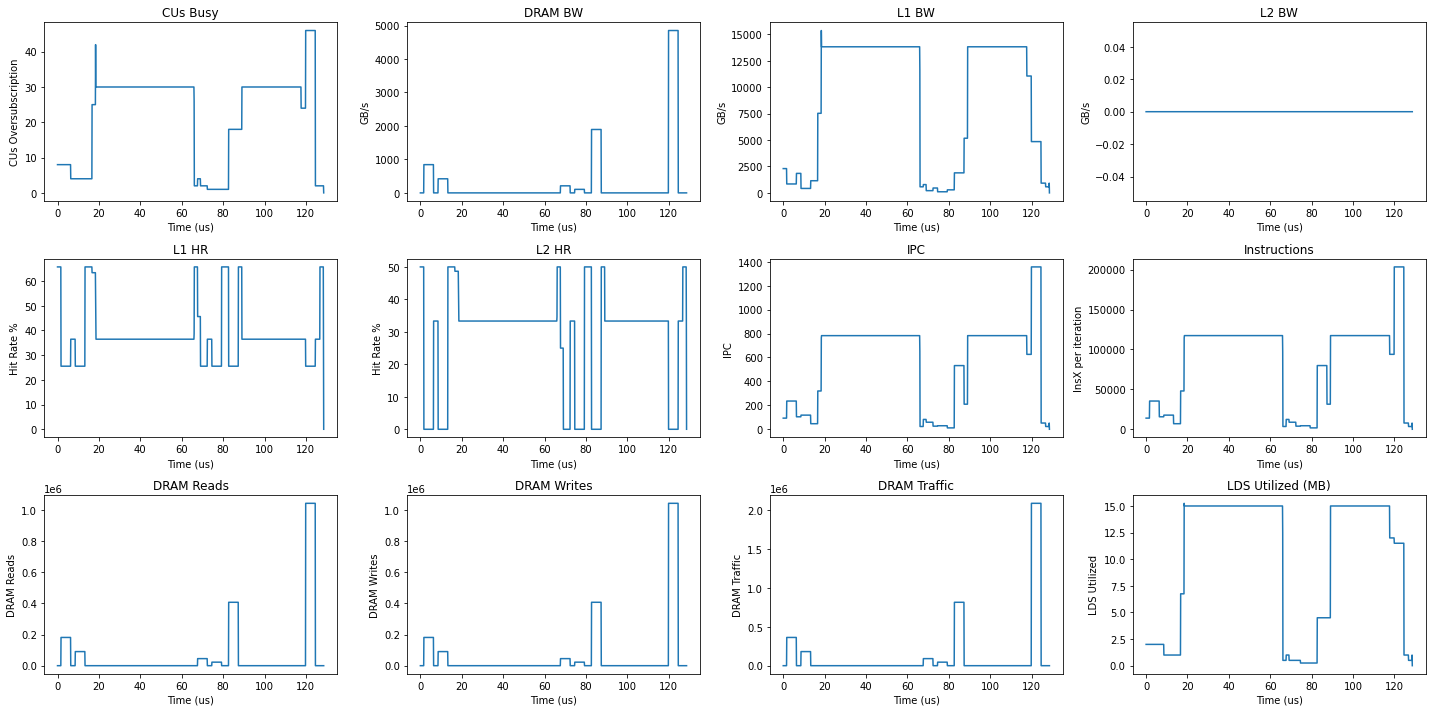

In [ ]:
# Metrics
# CUs_busy = []
# DRAM_BW = []
# L1_BW = []
# L2_BW = []
# L1_HR = []
# L2_HR = []
# IPC = []
# instx = []
# DRAM_reads = []
# DRAM_writes = []
# dram_traffic = []

def plot_metrics_df(metrics_df):
    # Plot metrics using seaborn
    # Create a subplot for each metric
    fig, axes = plt.subplots(3, 4, figsize=(20, 10))
    # Plot CUs busy
    sns.lineplot(x='Tick', y='CUs Busy', data=metrics_df, ax=axes[0, 0])
    axes[0, 0].set_title('CUs Busy')
    axes[0, 0].set_ylabel('CUs Oversubscription')
    axes[0, 0].set_xlabel('Time (us)')
    # Plot DRAM BW
    sns.lineplot(x='Tick', y='DRAM BW', data=metrics_df, ax=axes[0, 1])
    axes[0, 1].set_title('DRAM BW')
    axes[0, 1].set_ylabel('GB/s')
    axes[0, 1].set_xlabel('Time (us)')
    # Plot L1 BW
    sns.lineplot(x='Tick', y='L1 BW', data=metrics_df, ax=axes[0, 2])
    axes[0, 2].set_title('L1 BW')
    axes[0, 2].set_ylabel('GB/s')
    axes[0, 2].set_xlabel('Time (us)')
    # Plot L2 BW
    sns.lineplot(x='Tick', y='L2 BW', data=metrics_df, ax=axes[0, 3])
    axes[0, 3].set_title('L2 BW')
    axes[0, 3].set_ylabel('GB/s')
    axes[0, 3].set_xlabel('Time (us)')
    # Plot L1 HR
    sns.lineplot(x='Tick', y='L1 HR', data=metrics_df, ax=axes[1, 0])
    axes[1, 0].set_title('L1 HR')
    axes[1, 0].set_ylabel('Hit Rate %')
    axes[1, 0].set_xlabel('Time (us)')
    # Plot L2 HR
    sns.lineplot(x='Tick', y='L2 HR', data=metrics_df, ax=axes[1, 1])
    axes[1, 1].set_title('L2 HR')
    axes[1, 1].set_ylabel('Hit Rate %')
    axes[1, 1].set_xlabel('Time (us)')
    # Plot IPC
    sns.lineplot(x='Tick', y='IPC', data=metrics_df, ax=axes[1, 2])
    axes[1, 2].set_title('IPC')
    axes[1, 2].set_ylabel('IPC')
    axes[1, 2].set_xlabel('Time (us)')
    # Plot Instructions
    sns.lineplot(x='Tick', y='Instructions', data=metrics_df, ax=axes[1, 3])
    axes[1, 3].set_title('Instructions')
    axes[1, 3].set_ylabel('InsX per iteration')
    axes[1, 3].set_xlabel('Time (us)')
    # Plot DRAM Reads
    sns.lineplot(x='Tick', y='DRAM Reads', data=metrics_df, ax=axes[2, 0])
    axes[2, 0].set_title('DRAM Reads')
    axes[2, 0].set_xlabel('Time (us)')
    # axes[2, 0].set_ylabel('GT/s')
    # Plot DRAM Writes
    sns.lineplot(x='Tick', y='DRAM Writes', data=metrics_df, ax=axes[2, 1])
    axes[2, 1].set_title('DRAM Writes')
    axes[2, 1].set_xlabel('Time (us)')
    # axes[2, 1].set_ylabel('GT/s')
    # Plot DRAM Traffic
    sns.lineplot(x='Tick', y='DRAM Traffic', data=metrics_df, ax=axes[2, 2])
    axes[2, 2].set_title('DRAM Traffic')
    axes[2, 2].set_xlabel('Time (us)')
    # axes[2, 2].set_ylabel('GT/s')
    # Plot DRAM Traffic
    sns.lineplot(x='Tick', y='LDS Utilized', data=metrics_df, ax=axes[2, 3])
    axes[2, 3].set_title('LDS Utilized (MB)')
    axes[2, 3].set_xlabel('Time (us)')
    # axes[2, 3].set_ylabel('GT/s')
    # Tight layout
    plt.tight_layout()
    # Show plot
    plt.show()

plot_metrics_df(metrics_df)



In [ ]:
Total_threads = 120 * 4 * 64
print('Total threads: ' + str(Total_threads))

Total threads: 30720


In [ ]:
# metrics_df

In [ ]:
# block_data

In [ ]:
# block_data

In [ ]:
for i in range(len(DRAM_BW)):
    if DRAM_BW[i] > 0:
        print('DRAM BW: ' + str(DRAM_BW[i]) + ' at ' + str(i))
        break

DRAM BW: 843.6825053995681 at 17
